<a href="https://colab.research.google.com/github/hanansuk/guns_n_roses/blob/main/lme_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing Input Data for Modeling
Written by Hannah George

## Imports

In [2]:
!pip install --upgrade -q pip
!pip install -q torch
!pip install -q transformers
!pip install -q wordcloud

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at 

In [3]:
from datetime import datetime
from sklearn.decomposition import NMF
# from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import MaxAbsScaler
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords as nltk_stopwords

## Reading in the Data

In [4]:
deaths = pd.read_csv('cdc_monthly_state_gun_deaths_imputed.csv')
laws = pd.read_csv('RAND.csv')

In [5]:
deaths.head()

,Unnamed: 0,state,year,period,monthly_gun_deaths
0,0,Alabama,2021,2021-01-01,122.0
1,1,Alabama,2021,2021-02-01,104.0
2,2,Alabama,2021,2021-03-01,103.0
3,3,Alabama,2021,2021-04-01,102.0
4,4,Alabama,2021,2021-05-01,108.0


In [6]:
laws.head(10)

,Law.ID,State,State.Postal.Abbreviation,FIPS.Code,Law.Class..num.,Law.Class,Law.Class.Subtype,Handguns.or.Long.Guns,Effect,Type.of.Change,...,Supersession.Date,Supersession.Date.Year,Supersession.Date.Month,Supersession.Date.Day,Controlling.Law.at.Beginning.of.Period..1979.,Age.for.Minimum.Age.Laws,Length.of.Waiting.Period..days..handguns.,Additional.Context.and.Notes,Caveats.and.Ambiguities,Exception.Code
0,AK1001,Alaska,AK,2,1,background checks,private sales,handgun,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,AK1002,Alaska,AK,2,2,carrying a concealed weapon (ccw),prohibited,handgun,Restrictive,Implement,...,1994-10-01,1994.0,10.0,1.0,1,NaN,NaN,Prior law prohibiting concealed carry enacted ...,NaN,NaN
2,AK1003,Alaska,AK,2,2,carrying a concealed weapon (ccw),shall issue,handgun,Permissive,Modify,...,2003-09-09,2003.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
3,AK1004,Alaska,AK,2,2,carrying a concealed weapon (ccw),shall issue (permit not required),handgun,Permissive,Modify,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Permitting system maintained for residents see...,NaN,NaN
4,AK1005,Alaska,AK,2,3,castle doctrine,NaN,handgun and/or long gun,Permissive,Modify,...,2006-09-13,2006.0,9.0,13.0,1,NaN,NaN,See 2006 S.B. No. 200 Ch. 68.,NaN,NaN
5,AK1006,Alaska,AK,2,3,castle doctrine,expanded 2,handgun and/or long gun,Permissive,Modify,...,2013-09-18,2013.0,9.0,18.0,NaN,NaN,NaN,NaN,Catagorized as expanded 2 because removes duty...,NaN
6,AK1007,Alaska,AK,2,4,child access laws,"intentional, reckless, or knowing provision",handgun and/or long gun,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
7,AK1008,Alaska,AK,2,5,dealer license,NaN,handgun,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
8,AK1009,Alaska,AK,2,7,minimum age,youth possession,long gun,Restrictive,Implement,...,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN
9,AK1010,Alaska,AK,2,7,minimum age,youth possession,handgun,NaN,NaN,...,1980-01-01,1980.0,1.0,1.0,1,NaN,NaN,NaN,NaN,H


## Data Preprocessing

### Filtering Laws Dataset to Reduce Volume

In [7]:
filtered_laws = laws[laws['Type.of.Change'].isin(['Permissive', 'Implement'])].reset_index().copy()

### Converting Dates to Datetime Objects

In [8]:
deaths['period'] = pd.to_datetime(deaths.period)
filtered_laws['Effective.Date'] = pd.to_datetime(filtered_laws['Effective.Date'])
filtered_laws['Supersession.Date'] = pd.to_datetime(filtered_laws['Supersession.Date'])
# If the law has not been superseded, set the date to the future
filtered_laws['Supersession.Date'] = filtered_laws['Supersession.Date'].fillna('2099-12-01')

### Creating Lagged Monthly Gun Deaths Variable

In [9]:
# Compute prior monthly deaths
deaths['prior_monthly_deaths'] = deaths.groupby(['state'])['monthly_gun_deaths'].shift(1)

### Using NMF Topic Modeling to Transform Gun Laws

In [10]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Get the English stopwords
stopwords = set(nltk_stopwords.words('english'))

# Remove stopwords from tokens
def remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
len(filtered_laws)

1118

In [13]:
# Get text data
texts = filtered_laws.Content.tolist()

In [14]:
len(texts)

1118

In [15]:
# Tokenize and filter tokens
filtered_tokens = []
all_filtered_tokens = []
pattern = re.compile(r"\b(\w+)\b")  # Regular expression pattern to match whole words

for text in texts:
    tokens = tokenizer.tokenize(text)
    filtered_tokens_topic = [token.lower() for token in tokens if pattern.match(token) and token.lower() not in stopwords]
    all_filtered_tokens.append(filtered_tokens_topic)

# Truncate sequences to maximum length of 512 tokens
max_seq_length = 512
filtered_tokens_truncated = [seq[:max_seq_length] for seq in all_filtered_tokens]

In [16]:
len(filtered_tokens_truncated)

1118

In [17]:
# Convert tokens to input IDs for each text separately
input_ids_list = [tokenizer.convert_tokens_to_ids(tokens) for tokens in filtered_tokens_truncated]

# Determine the maximum sequence length among all texts
max_seq_length = max(len(tokens) for tokens in input_ids_list)

# Pad sequences to the maximum length
input_ids_padded = [tokens + [0] * (max_seq_length - len(tokens)) for tokens in input_ids_list]

# Convert padded input IDs to PyTorch tensor
input_ids_tensor = torch.tensor(input_ids_padded)
print(f"Input IDs Tensor Shape: {input_ids_tensor.shape}")

Input IDs Tensor Shape: torch.Size([1118, 512])


In [18]:
# Adjust tensor shape to match expected input shape
seq_length = min(input_ids_tensor.shape[1], 512)  # Maximum sequence length of 512 tokens
input_ids_tensor = input_ids_tensor[:, :seq_length]

In [19]:
# Extract BERT embeddings
with torch.no_grad():
    outputs = model(input_ids_tensor)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Extract the [CLS] token embeddings
print(f"Embeddings Shape: {embeddings.shape}")

Embeddings Shape: (1118, 768)


In [20]:
# Scale the embeddings to ensure non-negativity
scaler = MaxAbsScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Adjust the embeddings to make them non-negative
embeddings_scaled += np.abs(embeddings_scaled.min())

In [21]:
len(outputs)

2

In [22]:
# Apply topic modeling using NMF
n_topics = 20
nmf = NMF(n_components=n_topics, init='random')
topics = nmf.fit_transform(embeddings_scaled)
print(len(topics))
topic_col_names = [f'topic_{i}' for i in range(n_topics)]

# Create a DataFrame for topic probabilities
topics_df = pd.DataFrame(data=topics, columns=topic_col_names)

1118


In [23]:
print(topics.shape)
print(topics_df.head())

(1118, 20)
    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0  0.595653  0.656855  0.055646  0.090330  0.789340  0.031487  0.200680   
1  0.513505  0.000000  1.055667  0.000000  0.109554  0.088013  0.000000   
2  0.896441  0.363862  0.001175  0.066113  1.008212  0.000000  0.104936   
3  0.513505  0.000000  1.055667  0.000000  0.109554  0.088013  0.000000   
4  0.896441  0.363862  0.001175  0.066113  1.008212  0.000000  0.104936   

    topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  \
0  0.093779  0.000000  0.023358  1.203131  0.190906  0.000355  0.015564   
1  0.109644  1.008424  0.052675  0.004537  0.381805  0.000000  0.300764   
2  0.118275  0.160785  0.000000  0.742891  0.000000  0.045380  0.000000   
3  0.109644  1.008424  0.052675  0.004537  0.381805  0.000000  0.300764   
4  0.118275  0.160785  0.000000  0.742891  0.000000  0.045380  0.000000   

   topic_14  topic_15  topic_16  topic_17  topic_18  topic_19  
0  0.095054  0.115747  

In [24]:
# Reset the index of the topics_df DataFrame
topics_df = topics_df.reset_index(drop=True)

# Merge filtered_laws with topics_df based on the index
gun_law_topics = filtered_laws.merge(topics_df, left_index=True, right_index=True)

# Reset the index of the resulting DataFrame
gun_law_topics = gun_law_topics.reset_index(drop=True)

In [25]:
topic_csv = gun_law_topics.copy()
topic_csv.rename({
    'Law.ID': 'law_id',
    'State': 'state',
    'Content': 'content'}, axis=1, inplace=True)
topic_csv = topic_csv[['law_id', 'state', 'content'] + topic_col_names]

In [26]:
topic_col_names

['topic_0',
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4',
 'topic_5',
 'topic_6',
 'topic_7',
 'topic_8',
 'topic_9',
 'topic_10',
 'topic_11',
 'topic_12',
 'topic_13',
 'topic_14',
 'topic_15',
 'topic_16',
 'topic_17',
 'topic_18',
 'topic_19']

In [27]:
gun_law_topics.head(5)

,index,Law.ID,State,State.Postal.Abbreviation,FIPS.Code,Law.Class..num.,Law.Class,Law.Class.Subtype,Handguns.or.Long.Guns,Effect,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,1,AK1002,Alaska,AK,2,2,carrying a concealed weapon (ccw),prohibited,handgun,Restrictive,...,1.203131,0.190906,0.000355,0.015564,0.095054,0.115747,0.000000,0.304957,0.137438,0.054275
1,8,AK1009,Alaska,AK,2,7,minimum age,youth possession,long gun,Restrictive,...,0.004537,0.381805,0.000000,0.300764,0.693462,0.067648,0.000000,0.118978,0.360570,0.165948
2,10,AK1011,Alaska,AK,2,7,minimum age,purchase and sale,long gun,Restrictive,...,0.742891,0.000000,0.045380,0.000000,0.059510,0.696403,0.175645,0.000000,0.066252,0.062915
3,13,AK1015,Alaska,AK,2,7,minimum age,youth possession,handgun,Restrictive,...,0.004537,0.381805,0.000000,0.300764,0.693462,0.067648,0.000000,0.118978,0.360570,0.165948
4,14,AK1016,Alaska,AK,2,7,minimum age,purchase and sale,handgun,Restrictive,...,0.742891,0.000000,0.045380,0.000000,0.059510,0.696403,0.175645,0.000000,0.066252,0.062915


In [28]:
gun_law_topics.tail(5)

,index,Law.ID,State,State.Postal.Abbreviation,FIPS.Code,Law.Class..num.,Law.Class,Law.Class.Subtype,Handguns.or.Long.Guns,Effect,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
1113,2727,WY1037,Wyoming,WY,56,1,background checks,sales from dealer : federal,long gun,Restrictive,...,0.000000,0.000000,0.000000,0.327075,0.175692,0.033307,1.157849,0.043097,0.000000,0.083080
1114,2732,WY1042,Wyoming,WY,56,13,waiting period,federal,handgun,Restrictive,...,0.056359,0.082113,0.194549,0.155386,0.000000,0.000000,0.874899,0.209906,0.224034,0.319714
1115,2736,WY1046,Wyoming,WY,56,13,firearms in college/university,public and private : CCW not allowed,handgun,Restrictive,...,0.250905,0.292304,0.117190,0.300512,0.036813,0.597057,0.000000,0.112969,0.748407,0.017652
1116,2738,WY1048,Wyoming,WY,56,19,local laws preempted by state,comprehensive,handgun and/or long gun,Permissive,...,0.000000,0.287567,0.217770,0.181221,0.132328,0.166760,0.121082,0.353963,0.000000,0.000000
1117,2741,WY1051,Wyoming,WY,56,15,firearms in K-12 educational settings,school personnel other than peace officers,handgun and/or long gun,Restrictive,...,0.020262,0.000000,0.120051,0.028578,0.165248,0.000000,0.074948,0.029288,0.000000,0.062215


In [29]:
gun_law_topics.shape

(1118, 48)

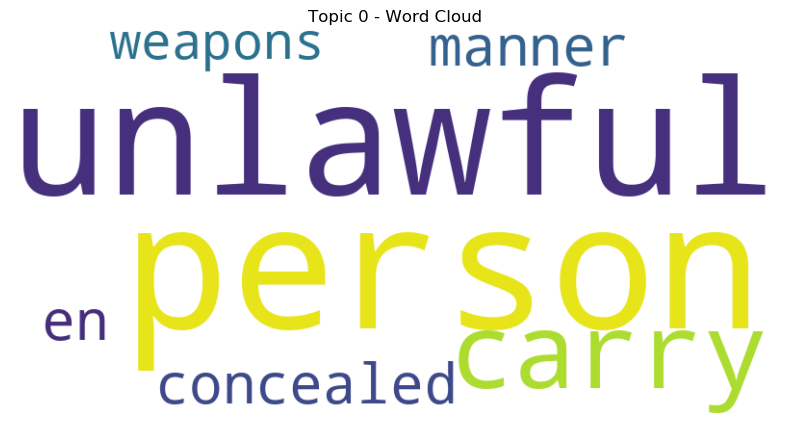

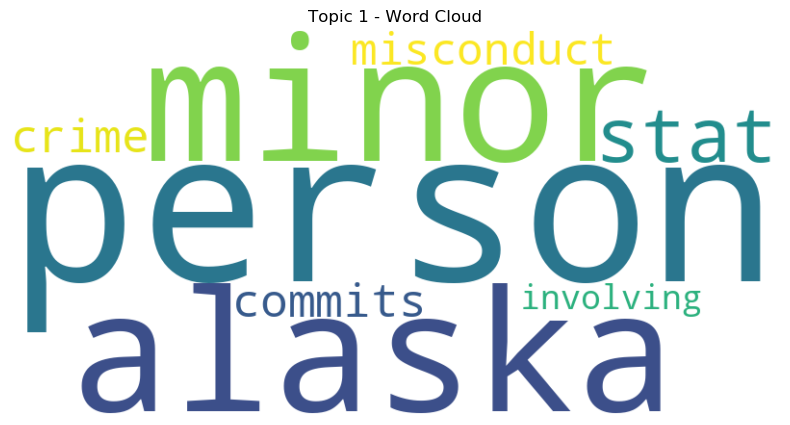

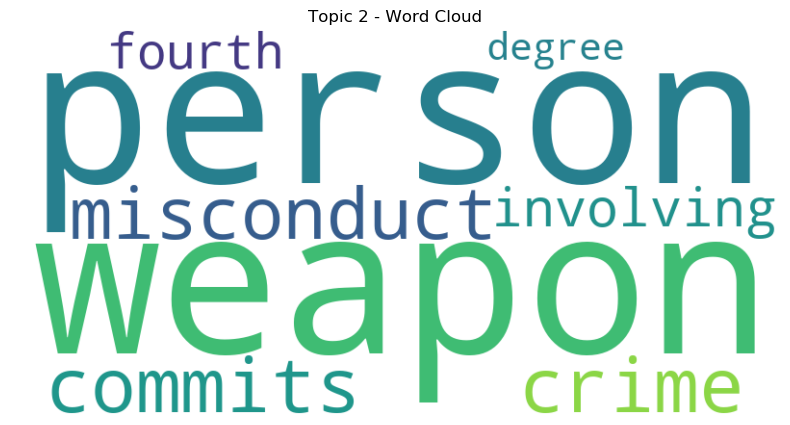

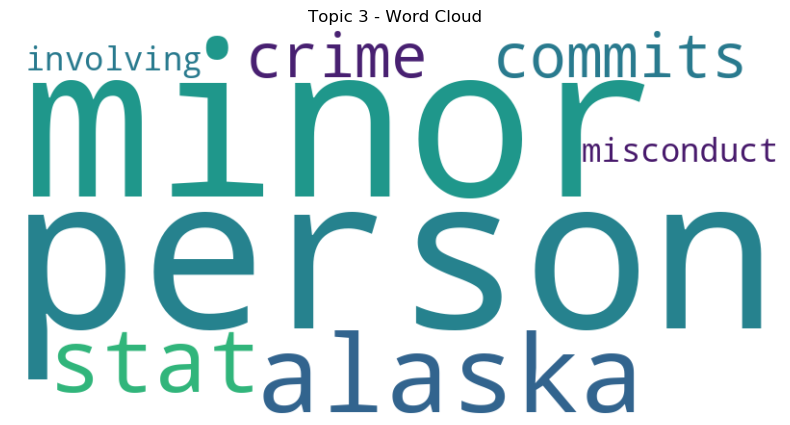

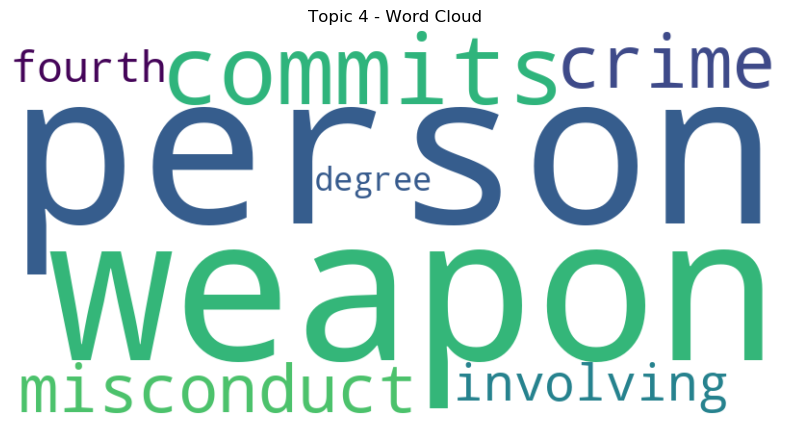

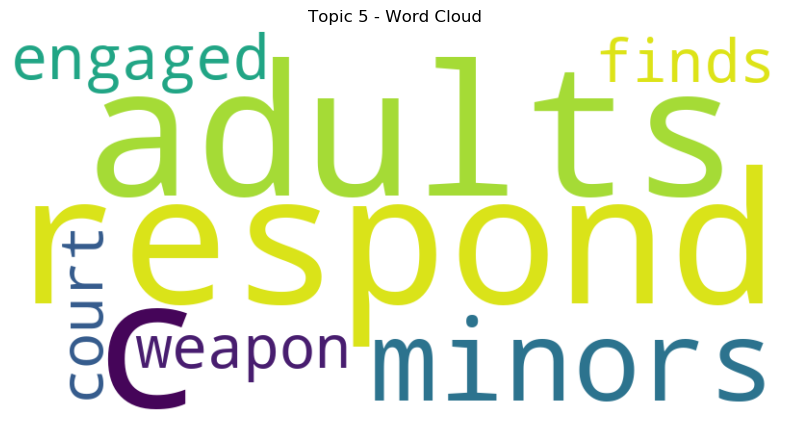

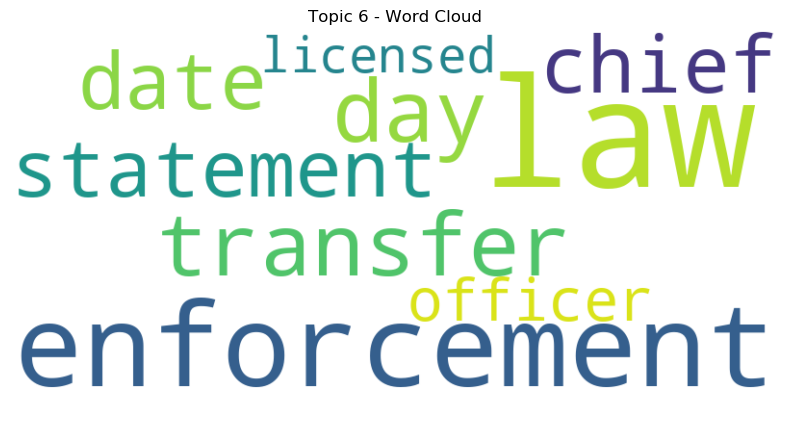

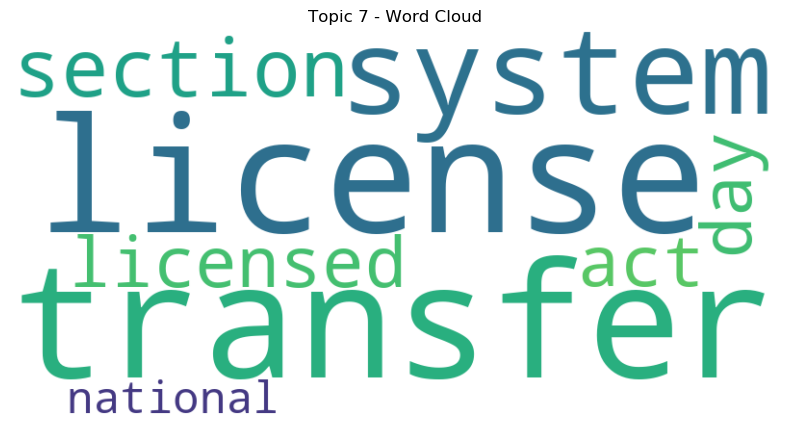

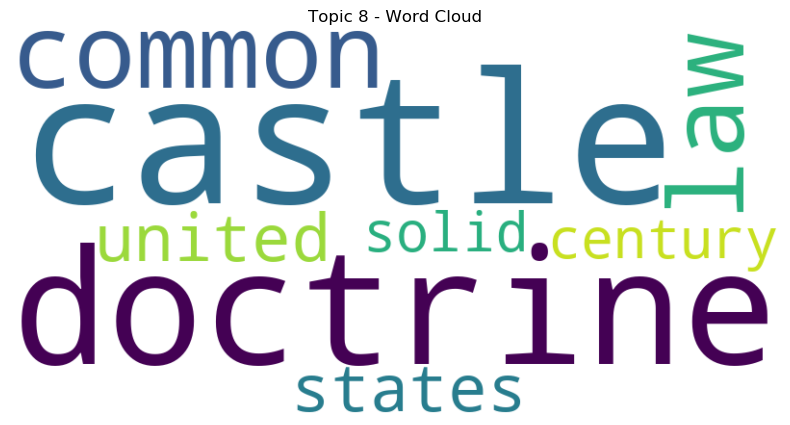

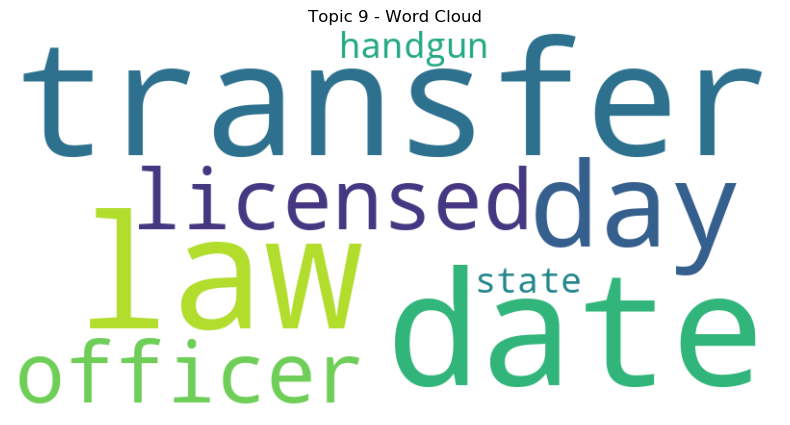

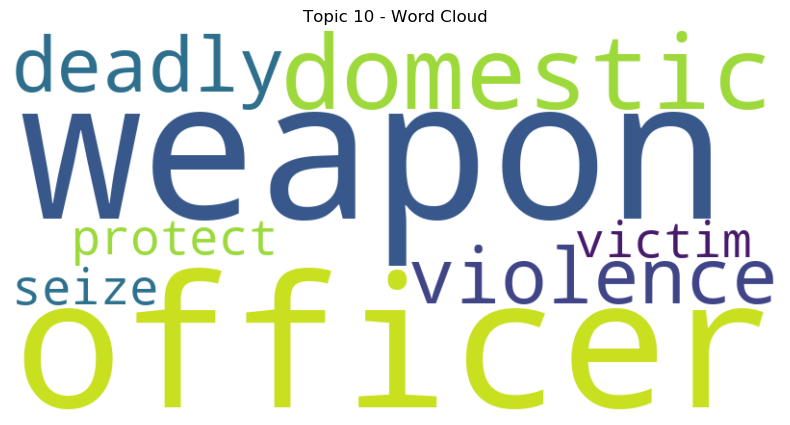

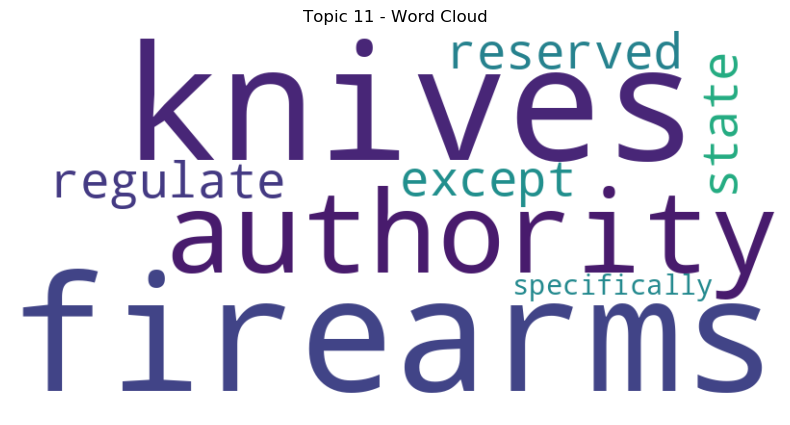

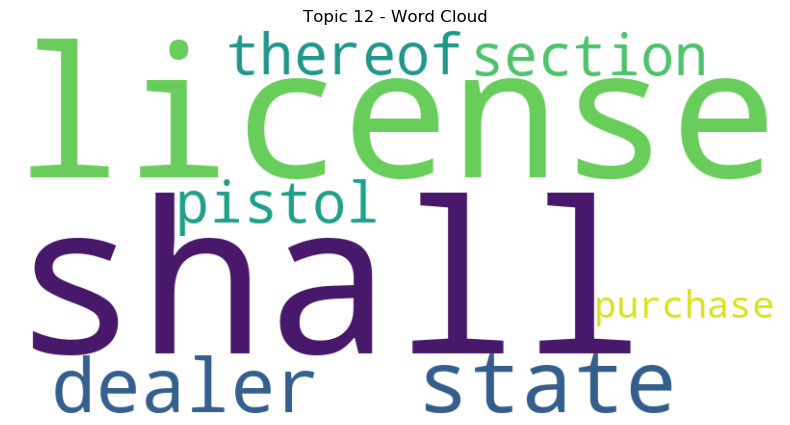

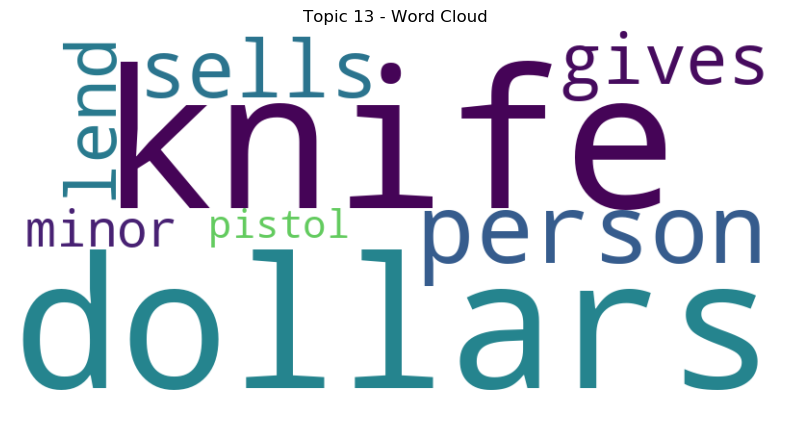

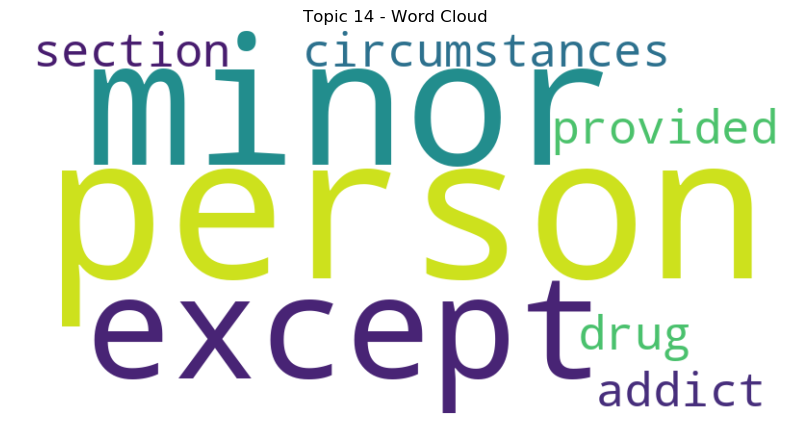

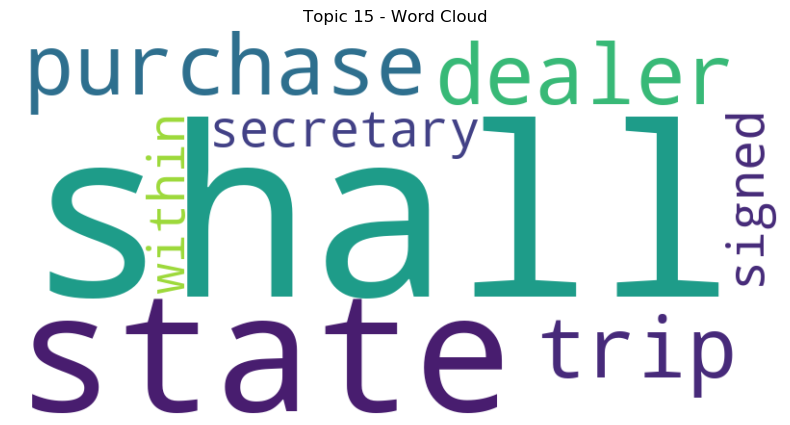

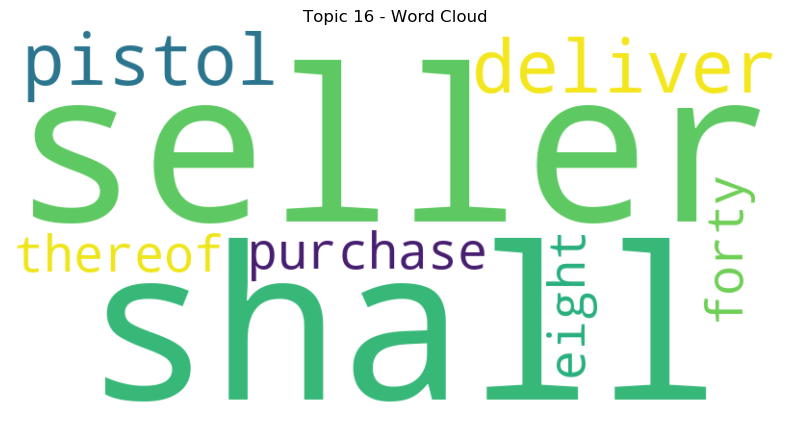

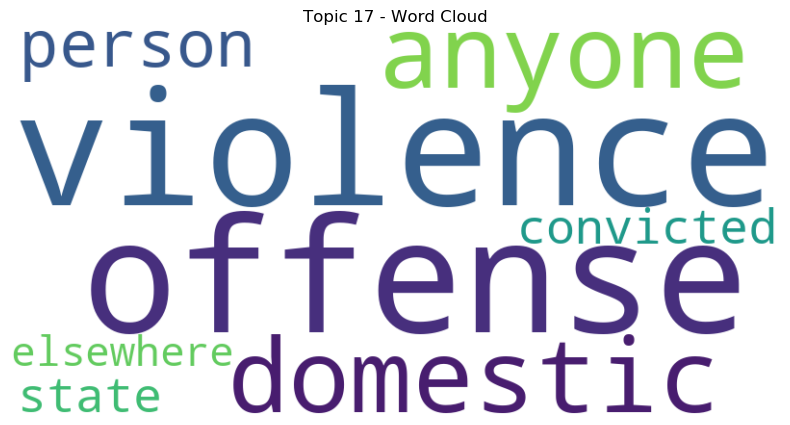

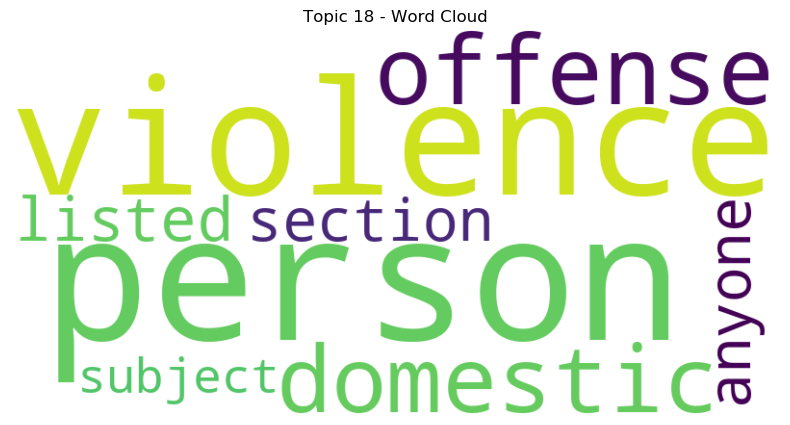

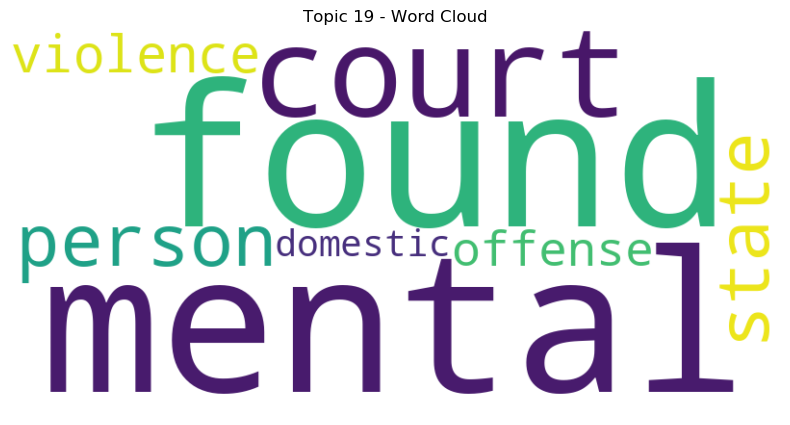

In [30]:
# Function to remove unused tokens
def remove_unused_tokens(tokens):
    pattern = re.compile(r"unused\d+")
    filtered_tokens = []
    for token_seq in tokens:
        seq_tokens = []
        for token in token_seq:
            token_str = str(token)
            if not pattern.match(token_str):
                seq_tokens.append(token_str)
        filtered_tokens.append(seq_tokens)
    return filtered_tokens

def generate_wordcloud(filtered_tokens, n_words):
    wordcloud_text = " ".join(filtered_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(wordcloud_text)
    # Limit the number of displayed words
    wordcloud_words = wordcloud.process_text(wordcloud_text)
    sorted_words = sorted(wordcloud_words.items(), key=lambda x: x[1], reverse=True)[:n_words]
    wordcloud_text = " ".join(word for word, count in sorted_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(wordcloud_text)
    return wordcloud

# Generate word cloud for each topic
n_words = 8

for topic_idx in range(n_topics):
    tokens = filtered_tokens_truncated[topic_idx]

    if tokens:
        wordcloud = generate_wordcloud(tokens, n_words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_idx} - Word Cloud")
        plt.show()
    else:
        print(f"No valid tokens for Topic {topic_idx}")

### Creating a row for each law active during the time period

In [31]:
def find_active_laws(row: pd.Series):
    this_state_laws = gun_law_topics[gun_law_topics.State == row.state].copy()
    all_active_laws = this_state_laws[(row.period >= this_state_laws['Effective.Date']) & (row.period < this_state_laws['Supersession.Date'])].copy()
    if len(all_active_laws) > 0:
        all_active_laws = all_active_laws.assign(state=row.state)
        all_active_laws = all_active_laws.assign(period=row.period)
        all_active_laws = all_active_laws.assign(monthly_gun_deaths=row.monthly_gun_deaths)
        all_active_laws = all_active_laws.assign(prior_monthly_deaths=row.prior_monthly_deaths)
        topic_columns = [f"topic_{i}" for i in range(n_topics)]
        all_active_laws[topic_columns] = all_active_laws[topic_columns].fillna(0)  # Fill NaN values in topic_x columns with 0
        return all_active_laws

res = map(lambda row: find_active_laws(row[1]), deaths.iterrows())
res = pd.concat(res)

In [32]:
res.head()

,index,Law.ID,State,State.Postal.Abbreviation,FIPS.Code,Law.Class..num.,Law.Class,Law.Class.Subtype,Handguns.or.Long.Guns,Effect,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,state,period,monthly_gun_deaths,prior_monthly_deaths
12,55,AL1007,Alabama,AL,1,5,dealer license,NaN,handgun,Restrictive,...,0.322354,0.000000,0.037610,0.396583,0.000000,0.194382,Alabama,2021-01-01,122.0,NaN
13,59,AL1011,Alabama,AL,1,7,minimum age,purchase and sale,handgun,Restrictive,...,0.047345,0.311671,0.007145,0.259202,0.805303,0.000000,Alabama,2021-01-01,122.0,NaN
14,60,AL1012,Alabama,AL,1,7,minimum age,youth possession,handgun,Restrictive,...,0.138851,0.384629,0.062463,0.255101,0.231265,0.072953,Alabama,2021-01-01,122.0,NaN
17,70,AL1023,Alabama,AL,1,10,prohibited possessor,dvro,handgun and/or long gun,Restrictive,...,0.138362,0.855213,0.004833,0.022131,0.000000,0.106292,Alabama,2021-01-01,122.0,NaN
18,71,AL1024,Alabama,AL,1,10,prohibited possessor,mental health : adjudicated as mentally incomp...,handgun and/or long gun,Restrictive,...,0.000000,0.169956,0.000000,0.335435,0.000000,0.701241,Alabama,2021-01-01,122.0,NaN


### Filtering to Necessary Columns

In [33]:
maybe_columns = ['Law.Class', 'Law.Class.Subtype', 'Handguns.or.Long.Guns', 'Effect']
needed_columns = ['Law.ID',  'state', 'period', 'monthly_gun_deaths',
                  'prior_monthly_deaths'] + topic_col_names
all_columns = needed_columns + maybe_columns
output = res[all_columns].dropna().copy()
output = output.rename(columns={
    'Law.ID': 'law_id', 
    'Law.Class': 'law_class', 
    'Law.Class.Subtype': 'law_class_subtype', 
    'Handguns.or.Long.Guns': 'gun_type', 
    'Effect': 'effect'
})

In [34]:
output.head()

,law_id,state,period,monthly_gun_deaths,prior_monthly_deaths,topic_0,topic_1,topic_2,topic_3,topic_4,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,law_class,law_class_subtype,gun_type,effect
13,AL1011,Alabama,2021-02-01,104.0,122.0,0.429559,1.183802,0.000000,0.623459,0.352311,...,0.047345,0.311671,0.007145,0.259202,0.805303,0.000000,minimum age,purchase and sale,handgun,Restrictive
14,AL1012,Alabama,2021-02-01,104.0,122.0,0.573062,0.787449,0.000000,0.000000,0.935999,...,0.138851,0.384629,0.062463,0.255101,0.231265,0.072953,minimum age,youth possession,handgun,Restrictive
17,AL1023,Alabama,2021-02-01,104.0,122.0,0.726467,0.497169,0.000000,0.385304,0.766123,...,0.138362,0.855213,0.004833,0.022131,0.000000,0.106292,prohibited possessor,dvro,handgun and/or long gun,Restrictive
18,AL1024,Alabama,2021-02-01,104.0,122.0,0.574465,0.598209,0.000000,0.968115,0.000000,...,0.000000,0.169956,0.000000,0.335435,0.000000,0.701241,prohibited possessor,mental health : adjudicated as mentally incomp...,handgun and/or long gun,Restrictive
19,AL1025,Alabama,2021-02-01,104.0,122.0,0.716699,0.175451,0.870344,0.082434,0.085229,...,0.194122,0.185260,0.335467,0.509762,0.065243,1.272097,prohibited possessor,mental health : committed to mh facility,handgun and/or long gun,Restrictive


## Saving Results to CSV

In [35]:
output.to_csv('model_ready_v2.csv')

In [36]:
topic_csv.to_csv('gun_law_topic_scores_v2.csv', index=False)